In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

from sklearn.metrics import classification_report

import xgboost as xgb

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


# EDA

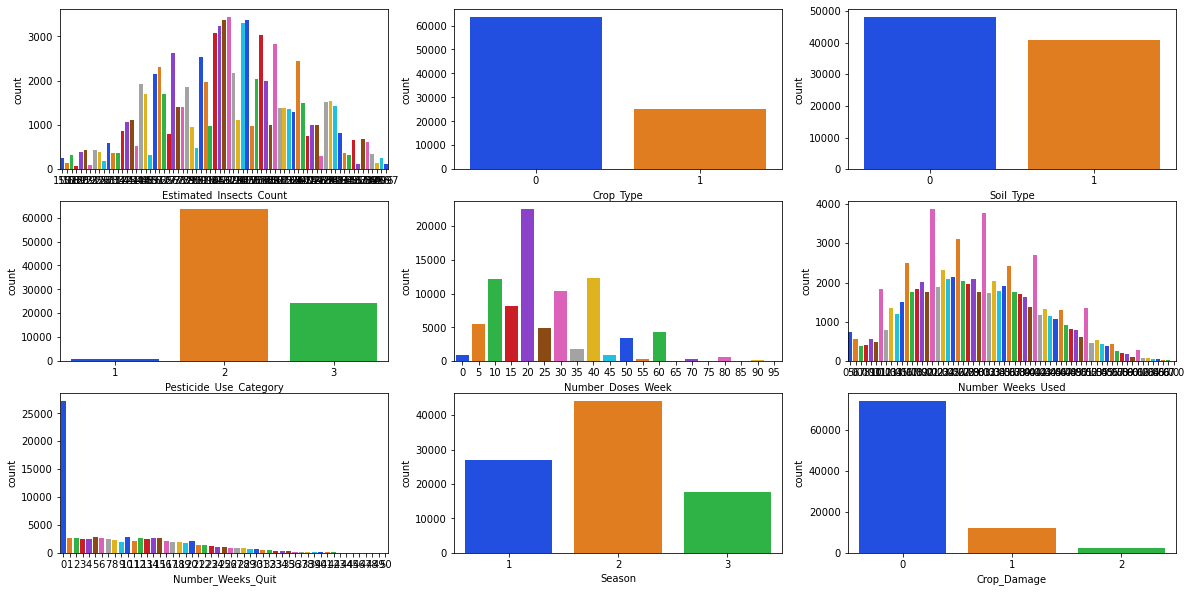

In [4]:
columns = list(train.columns)
columns.remove('ID')


fig, axes = plt.subplots(math.ceil(len(columns)/3),3, figsize = (20,10))
axes = axes.flatten()
for ax,c in zip(axes,columns):
    sns.countplot(x=c,data = train,palette = "bright",ax =ax)

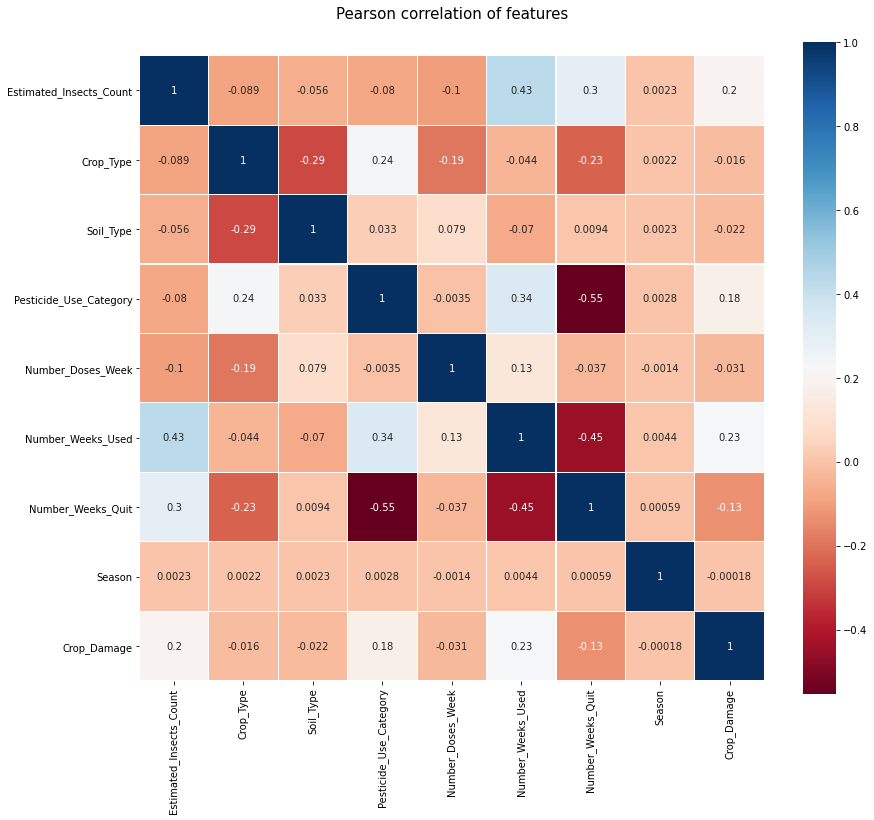

In [5]:
#correlation
columns = list(train.columns)
columns.remove('ID')
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson correlation of features',y=1.05,size=15)
sns.heatmap(train[columns].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [6]:
combine = [train,test]
for df in combine:
    df['Total_weeks'] = df['Number_Weeks_Used']+df['Number_Weeks_Quit']
    df['total_dose'] = df['Number_Weeks_Used']*df['Number_Doses_Week']

In [7]:
used_columns = ['Estimated_Insects_Count','Crop_Type','Soil_Type','Pesticide_Use_Category',
                'total_dose']
y = train['Crop_Damage']
trn = train[used_columns]
tst = test[used_columns]

In [ ]:
#imputer 
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# define the model
X_train = imputer.fit_transform(trn)
X_test = imputer.transform(tst)

X_train.shape

In [8]:
#xgb classifier( main)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

Xgb = XGBClassifier(
     learning_rate = 0.3,
     n_estimators=1000,
     min_child_weight=1,
     gamma=0,
     max_depth=7,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softmax',
     nthread=4,
     seed=27)


Xgb.fit(trn,y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
pred_train = Xgb.predict(trn)
#scoring accuracy

#accuracy_score(y.values,pred_train)
confusion_matrix(y.values,pred_train)

array([[72918,  1214,   106],
       [ 7780,  4425,   102],
       [ 1249,   457,   607]], dtype=int64)

In [11]:
#classification report

print(classification_report(y.values,pred_train)) 

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     74238
           1       0.73      0.36      0.48     12307
           2       0.74      0.26      0.39      2313

    accuracy                           0.88     88858
   macro avg       0.79      0.53      0.60     88858
weighted avg       0.86      0.88      0.86     88858



In [12]:
pred1 = Xgb.predict(tst)
test['Crop_Damage'] = pred1

In [13]:
final_sub = test[['ID','Crop_Damage']]
final_sub.to_csv('final_sub.csv',index=False)